# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from scipy.stats import ks_2samp
import pylab as plt
import pandas as pd

from sklearn import svm
from sklearn.metrics import roc_curve, auc


from functools import reduce

In [37]:
## Load data set and show some related information
df = pd.read_pickle('../cifar10_stats_df.pkl')

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))
print(datasets)

Index(['boundary_distance', 'delta_loss', 'direction_id', 'direction_type',
       'k', 'y', 'y_hat', 'ell2_grad', 'Dataset', 'Example#', 'Approx_conf'],
      dtype='object')
frame has 8 datasets and 1264 unique examples
['cifar10' 'FGM-0.02' 'FGM-0.03' 'FGM-0.05' 'FGM-0.10' 'FGM-0.15'
 'FGM-0.20' 'FGM-0.25']


cifar10 has 1264 examples
FGM-0.02 has 656 examples
FGM-0.03 has 873 examples
FGM-0.05 has 1086 examples
FGM-0.10 has 1194 examples
FGM-0.15 has 1209 examples
FGM-0.20 has 1215 examples
FGM-0.25 has 1205 examples
"cifar10" vs "FGM-0.02" : pvalue=6.22e-102
"cifar10" vs "FGM-0.03" : pvalue=1.1e-72
"cifar10" vs "FGM-0.05" : pvalue=3.1e-30
"cifar10" vs "FGM-0.10" : pvalue=1.05e-07
"cifar10" vs "FGM-0.15" : pvalue=2.04e-14
"cifar10" vs "FGM-0.20" : pvalue=8.5e-30
"cifar10" vs "FGM-0.25" : pvalue=6.05e-44
"FGM-0.02" vs "FGM-0.03" : pvalue=4.66e-09
"FGM-0.02" vs "FGM-0.05" : pvalue=1.1e-35
"FGM-0.02" vs "FGM-0.10" : pvalue=7.06e-62
"FGM-0.02" vs "FGM-0.15" : pvalue=2.07e-51
"FGM-0.02" vs "FGM-0.20" : pvalue=2.15e-34
"FGM-0.02" vs "FGM-0.25" : pvalue=1.22e-23
"FGM-0.03" vs "FGM-0.05" : pvalue=1.12e-14
"FGM-0.03" vs "FGM-0.10" : pvalue=3.87e-41
"FGM-0.03" vs "FGM-0.15" : pvalue=1.87e-28
"FGM-0.03" vs "FGM-0.20" : pvalue=2.13e-17
"FGM-0.03" vs "FGM-0.25" : pvalue=9.66e-11
"FGM-0.05" vs "FGM-0.10

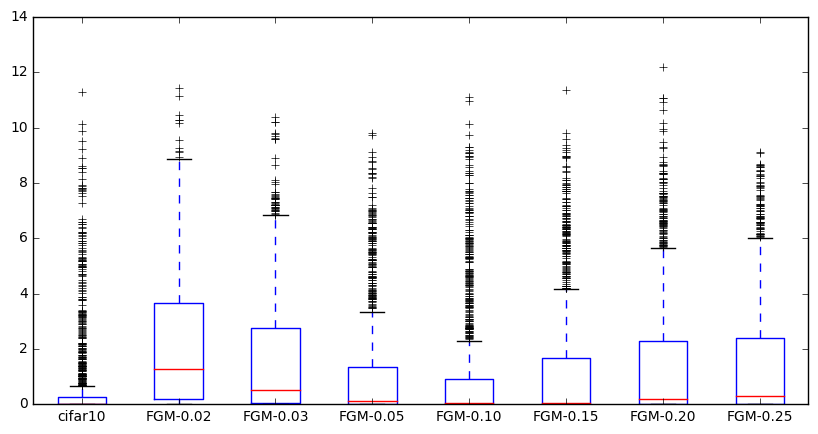

In [90]:
## Here we examine whether the gradient norm seems to be indicative
## of AE vs clean examples.

# Extract the sub-table corresponding only to the gradient-related rows.
df_grad_only = df[df['direction_type'] == 'gradient']

# Show distribution of gradient norms
gradient_norms = []
for idx, dset in enumerate(datasets):
    rows = (df_grad_only['Dataset'] == dset)
    n = np.sum(rows)
    print('%s has %d examples' % (dset, n))
    
    gradient_norms.append(df_grad_only['ell2_grad'][rows])

## visually inspect the distributions
plt.figure(figsize=(10,5))
plt.boxplot(gradient_norms, labels=datasets)
plt.plot()

#plt.figure()
#for ii in range(len(gradient_norms)):
#    plt.hist(np.log(gradient_norms[ii]), alpha=0.5, label=datasets[ii])
#plt.legend(loc='upper left')
#plt.show()


## Compare each AE distribution to the clean example distribution with a simple statistical test.

for ii in range(len(datasets)):
    for jj in range(ii+1,len(datasets)):
        comparison = [gradient_norms[ii], gradient_norms[jj]]
        _, pv = ks_2samp(*comparison)
        print('"%s" vs "%s" : pvalue=%0.3g' % (datasets[ii], datasets[jj], pv))


df0 shape: (1264, 11)
FGM-0.02
(656, 11)
FGM-0.03
(873, 11)
FGM-0.05
(1086, 11)
FGM-0.10
(1194, 11)
FGM-0.15
(1209, 11)
FGM-0.20
(1215, 11)
FGM-0.25
(1205, 11)


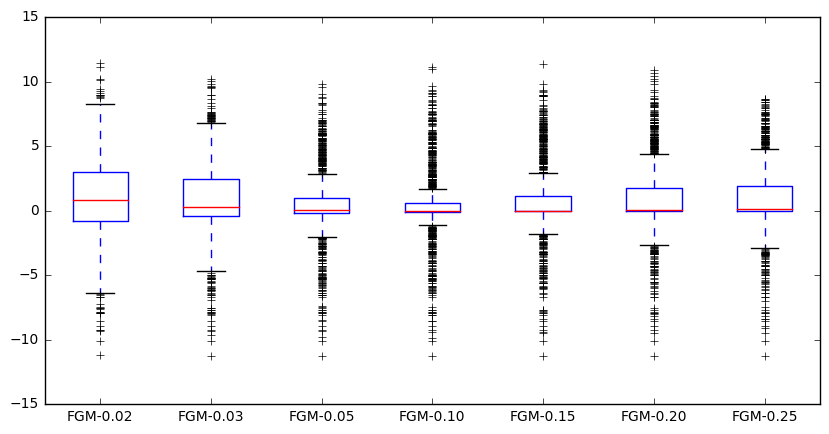

In [89]:
# look now at the per-example differences between ||J|| for clean vs AE.

all_pairwise_diffs = []
ae_datasets = [x for x in datasets if x != 'cifar10']


df0 = df_grad_only[ df_grad_only['Dataset'] == 'cifar10' ]
df0.sort_values('Example#')


for ds_name in ae_datasets:
    
    print(ds_name)
    df1 = df_grad_only[ df_grad_only['Dataset'] == ds_name ]
    df1.sort_values('Example#')
    print(df1.shape)

    in_both = df0['Example#'].isin(df1['Example#'])
    assert(np.sum(in_both) == df1.shape[0])
    
    delta = np.array(df1['ell2_grad']) - np.array(df0['ell2_grad'][in_both])
    all_pairwise_diffs.append(delta)
    
    
       
plt.figure(figsize=(10,5))
plt.boxplot(all_pairwise_diffs, labels=ae_datasets)
plt.show()

[ True False False False False False False False]


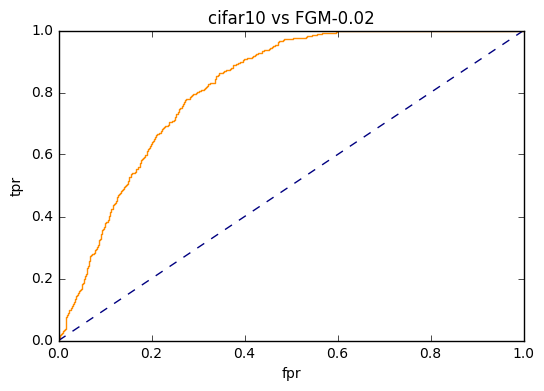

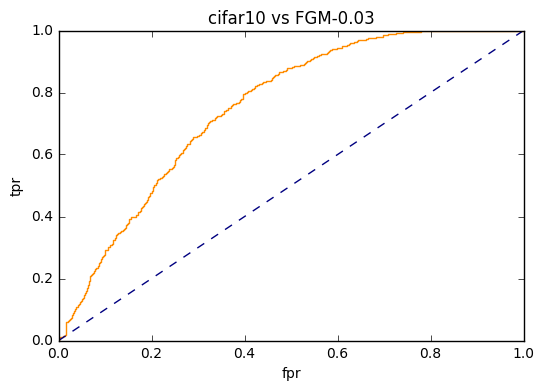

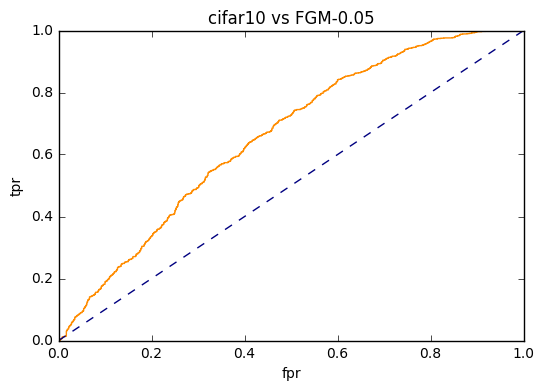

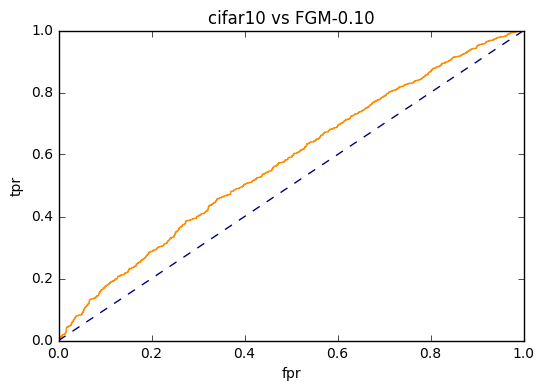

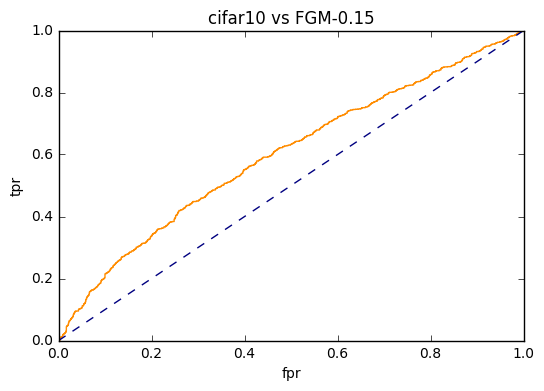

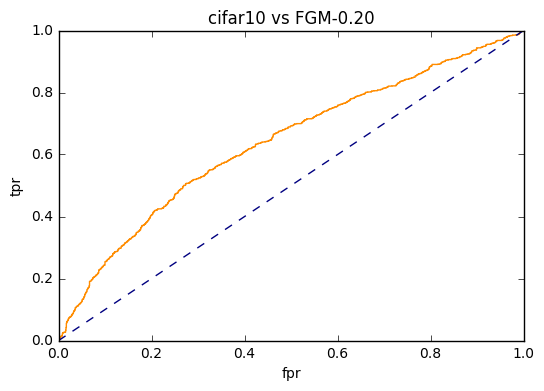

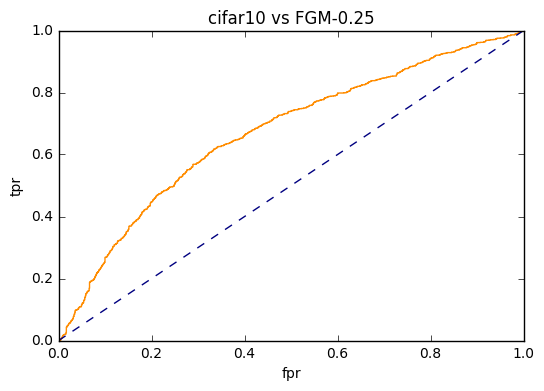

In [93]:
# consider the "classification" performance if we use a single feature, the gradient norm.
print(datasets == 'cifar10')
idx_0 = np.nonzero(datasets == 'cifar10')[0][0]

for idx_1 in range(len(datasets)):
    if idx_1 == idx_0:
        continue
    
    class_0 = gradient_norms[idx_0]
    class_1 = gradient_norms[idx_1]
    
    y_score = np.concatenate([class_0, class_1], axis=0)
    y_true = np.concatenate([np.zeros((len(class_0),)), np.ones((len(class_1),))])
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.plot([0,1], [0,1], color='navy', linestyle='--')
    plt.title('%s vs %s' % (datasets[idx_0], datasets[idx_1]))
    plt.xlabel('fpr');  plt.ylabel('tpr')
    plt.show()